In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import string
import pickle

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("spam.csv", encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Character Encoding:
Computers represent characters using numeric codes (e.g., ASCII, UTF-8, ISO-8859-1). Different encodings handle characters differently, especially non-ASCII characters (e.g., accented letters, special symbols). If the CSV file contains non-ASCII characters, specifying the correct encoding ensures they are read correctly. 
utf-8: Universal encoding that supports most characters worldwide.
latin-1 (ISO-8859-1): Common for Western European languages.
Other encodings exist for specific languages and regions.
Here, latin-1 has been used.

In [3]:
data = data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
# data['encoded_label'] = data['label'].map({'ham':0,'spam':1})
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
data = data.rename(columns={'v1':'label','v2':'message'})
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
data['encoded_label'] = data['label'].map({'ham':0,'spam':1})
data.head()

,label,message,encoded_label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [8]:
data.describe()

,encoded_label
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


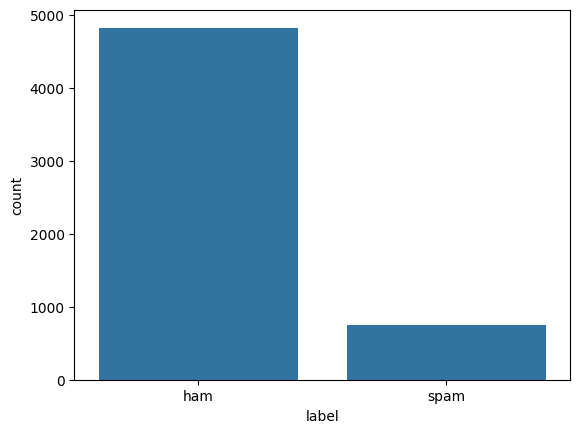

In [9]:
sns.countplot(x=data['label'])
plt.show()

In [10]:
avg_words_len=round(sum([len(i.split()) for i in data['message']])/len(data['message'])) 
print(avg_words_len)

15


In [11]:
s = set()
for i in data['message']:
    for word in i.split():
        s.add(word)
total_uniqe_words = len(s)
total_uniqe_words       

15585

In [12]:
x,y=np.asanyarray(data['message']),np.asanyarray(data['encoded_label'])
new_data = pd.DataFrame({'message':x,'label':y})
x_train,x_test,y_train,y_test = train_test_split(new_data['message'],new_data['label'],test_size=0.2,random_state=42)
x_test

3245    Funny fact Nobody teaches volcanoes 2 erupt, t...
944     I sent my scores to sophas and i had to do sec...
1044    We know someone who you know that fancies you....
2484    Only if you promise your getting out as SOON a...
812     Congratulations ur awarded either å£500 of CD ...
                              ...                        
4264     &lt;DECIMAL&gt; m but its not a common car he...
2439    Rightio. 11.48 it is then. Well arent we all u...
5556    Yes i have. So that's why u texted. Pshew...mi...
4205                               Get the door, I'm here
4293    Kit Strip - you have been billed 150p. Netcoll...
Name: message, Length: 1115, dtype: object

Numpy Arrays:
np.asanyarray(data['message']):This converts the message column from the DataFrame (data) into a NumPy array.The resulting array contains the text messages.
np.asanyarray(data['encoded_label']):Similarly, this converts the encoded_label column into a NumPy array.The resulting array contains the corresponding labels (0 or 1).

Creating a New DataFrame:
new_data = pd.DataFrame({'message': x, 'label': y}):This line creates a new DataFrame called new_data.It combines the message array (text messages) and the label array (encoded labels) into a single DataFrame.Each row in new_data corresponds to a message-label pair.

In [13]:
tfidf_vec = TfidfVectorizer().fit(x_train)
x_train_vec,x_test_vec = tfidf_vec.transform(x_train),tfidf_vec.transform(x_test)

# x_train_vec
baseline_model = MultinomialNB()
baseline_model.fit(x_train_vec,y_train)

nb_accuracy = accuracy_score(y_test,baseline_model.predict(x_test_vec))
print(nb_accuracy*100,"%")

96.23318385650225 %


In [14]:
print(classification_report(y_test,baseline_model.predict(x_test_vec)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



In [ ]:
# # plot_confusion_matrix(baseline_model,x_test_vec,y_test)
# ConfusionMatrixDisplay.from_estimator(baseline_model, x_test, y_test)
# plt.show()

In [15]:
Maxtokens = total_uniqe_words
outputline = avg_words_len 

text_vec = TextVectorization(
    max_tokens = Maxtokens,
    standardize = 'lower_and_strip_punctuation',
    output_mode = 'int',
    output_sequence_length = outputline
)
text_vec.adapt(x_train)

In [20]:
with open('tfidf_vec.pkl', 'wb') as file:
    pickle.dump(tfidf_vec, file)

with open('baseline_model.pkl', 'wb') as file:
    pickle.dump(baseline_model, file)

print("Models have been pickled successfully.")

Models have been pickled successfully.
